# Setup


In [1]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("dynamic-clustering"):
    os.chdir("..")
    print(os.getcwd())

c:\Users\manse\OneDrive\Desktop\dynamic-clustering


In [2]:
import numpy as np
import pandas as pd
from scripts.clusterer import CluStream
from scripts.dynamic_clusterer import DynamicClusterer
from scripts.utils import get_colors

import umap
import plotly.express as px
import matplotlib.pyplot as plt
import imageio
from river import drift

c:\Users\manse\OneDrive\Desktop\dynamic-clustering\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
colors = get_colors()

number of colors defined: 20


# Dataset


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bike_sharing = fetch_ucirepo(id=275)
"""
# metadata
print(bike_sharing.metadata)

# variable information
print(bike_sharing.variables)
"""

'\n# metadata\nprint(bike_sharing.metadata)\n\n# variable information\nprint(bike_sharing.variables)\n'

In [5]:
# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets

X = pd.concat([X, y], axis=1)

# Assuming your data is in a DataFrame named 'df'
# Ensure the 'dteday' column is in datetime format
X = X[["dteday", "workingday", "temp", "atemp", "hum", "windspeed", "cnt"]]

X["dteday"] = pd.to_datetime(X["dteday"])
# X = pd.get_dummies(X, columns=['hr', 'holiday', 'weathersit'])

# Group the DataFrame by month and year
grouped_df = X.groupby([X["dteday"].dt.year, X["dteday"].dt.month])


batches = []
targets = []
for (year, month), group in grouped_df:
    monthly_df = group.copy()
    batches.append(monthly_df)

In [6]:
targets = []
final_batches = []

for batch in batches:
    batch = batch.groupby(batch["dteday"].dt.date).mean()
    targets.append(batch["cnt"])

    batch = batch.drop(columns=["dteday", "cnt"])
    final_batches.append(batch)

In [7]:
reference = final_batches[0]
prods = final_batches[1:]

# Data preprocess


In [ ]:
complete_data = np.vstack(final_batches)

reducer = umap.UMAP(random_state=42)
# reducer = TSNE(n_components=2, random_state=0)
reduced_data = reducer.fit_transform(complete_data)

c:\Users\manse\OneDrive\Desktop\dynamic-clustering\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\manse\OneDrive\Desktop\dynamic-clustering\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
batches_len = [batch.shape[0] for batch in final_batches]

cumulative_sums = list(np.cumsum(batches_len))
print(cumulative_sums)

[np.int64(31), np.int64(59), np.int64(90), np.int64(120), np.int64(151), np.int64(181), np.int64(212), np.int64(243), np.int64(273), np.int64(304), np.int64(334), np.int64(365), np.int64(396), np.int64(425), np.int64(456), np.int64(486), np.int64(517), np.int64(547), np.int64(578), np.int64(609), np.int64(639), np.int64(670), np.int64(700), np.int64(731)]


In [10]:
batches_reduced = []
for i in range(len(cumulative_sums)):
    batches_reduced.append(
        reduced_data[cumulative_sums[i] - batches_len[i] : cumulative_sums[i], :]
    )

In [ ]:
# Assuming X_reduced is your 2D UMAP embedding and original_features is a DataFrame with original features
df = pd.DataFrame(batches_reduced[0], columns=["x", "y"])
df["original_features"] = (
    reference.values.tolist()
)  # Assuming original_features is a DataFrame

fig = px.scatter(df, x="x", y="y", hover_data=["original_features"])
fig.show()

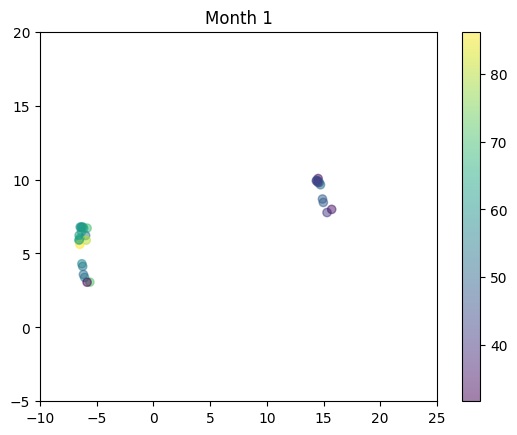

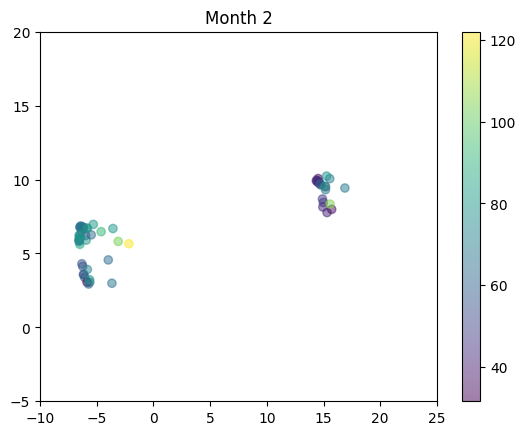

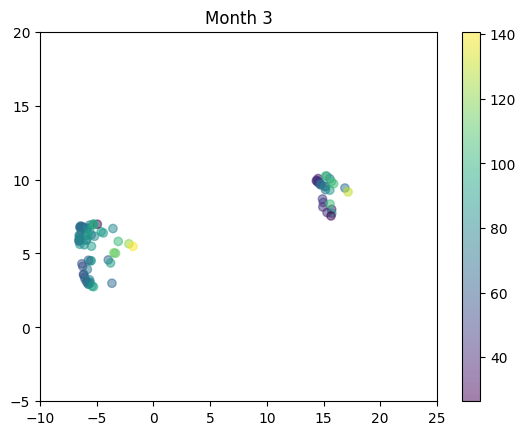

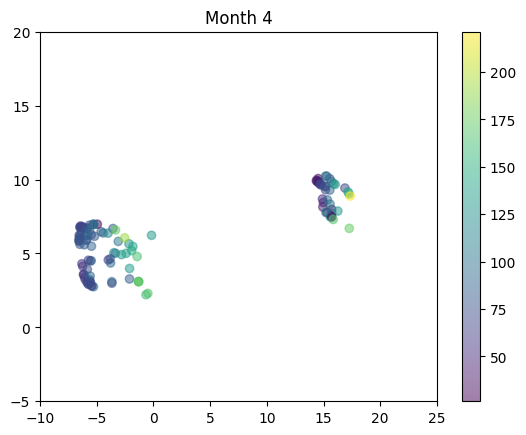

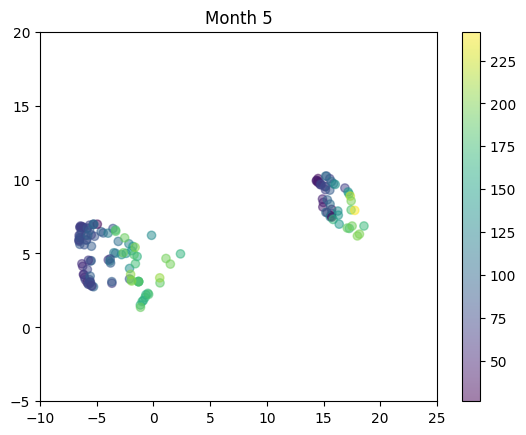

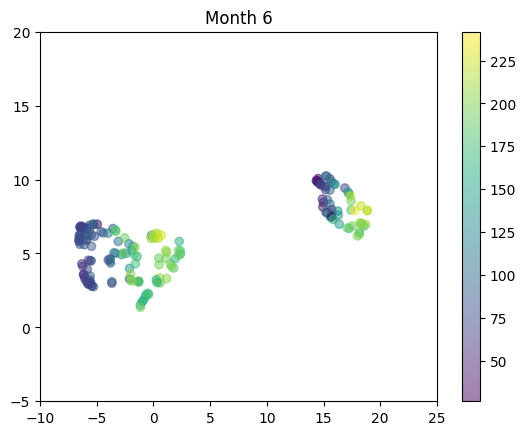

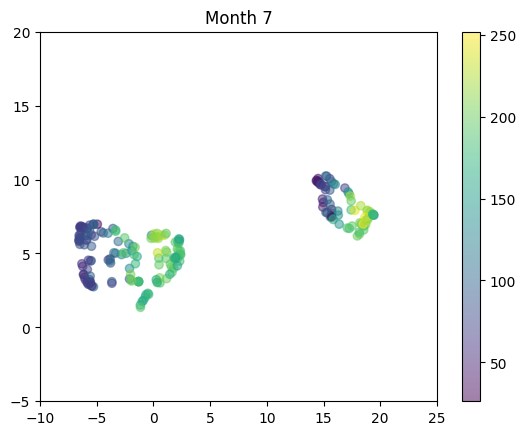

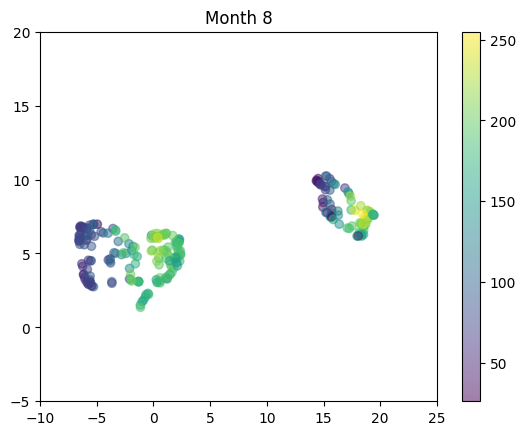

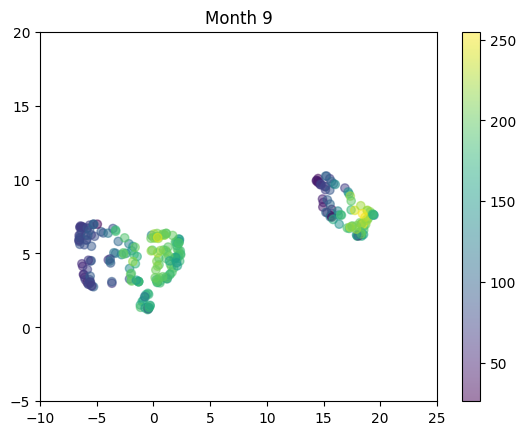

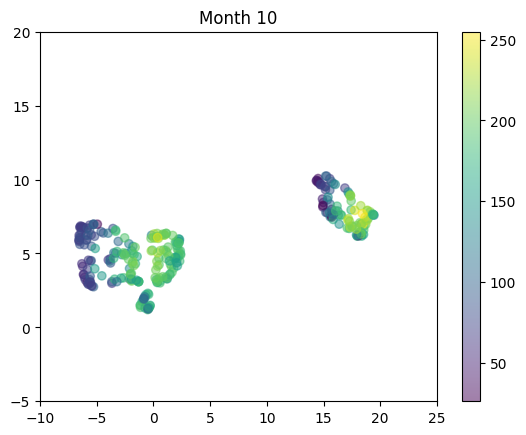

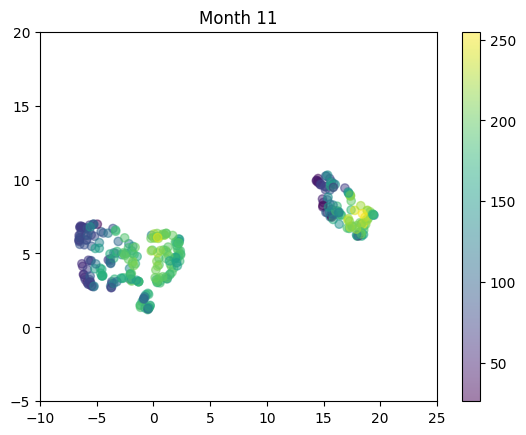

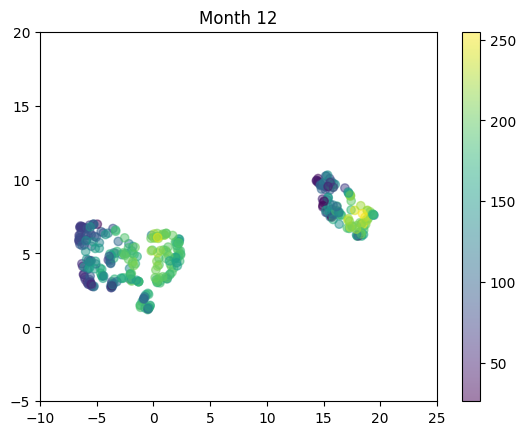

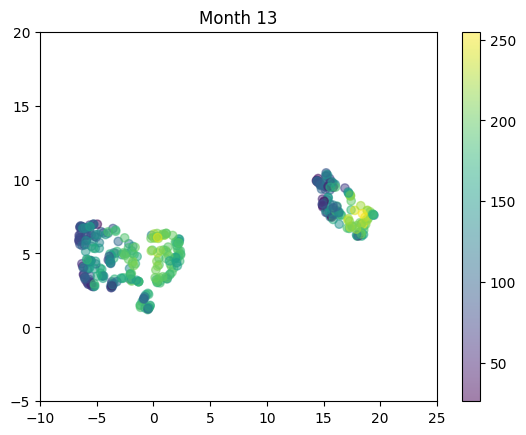

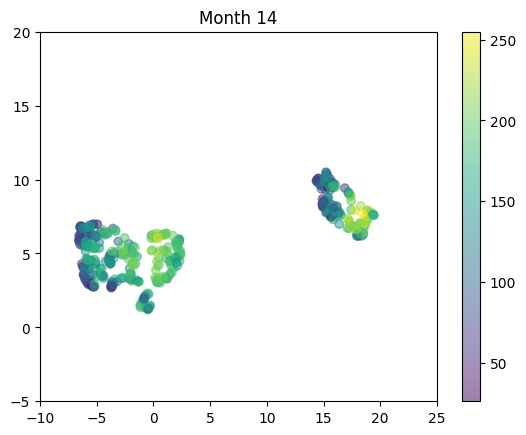

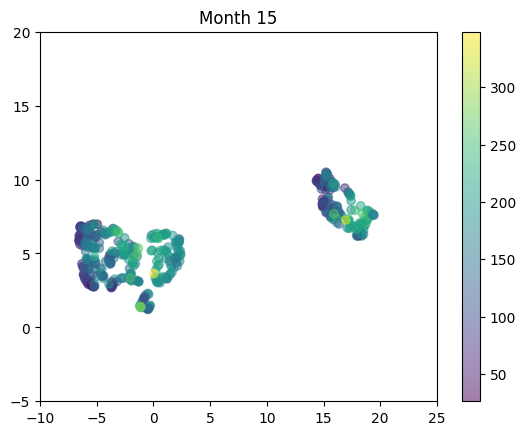

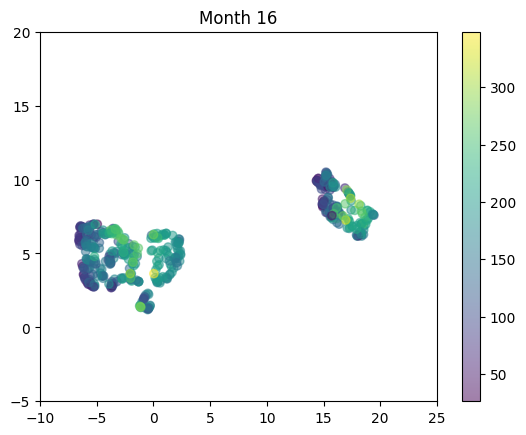

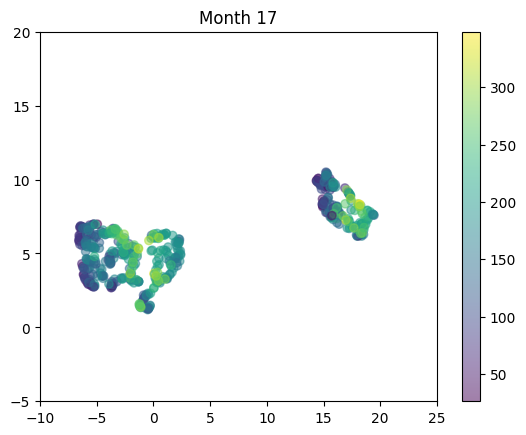

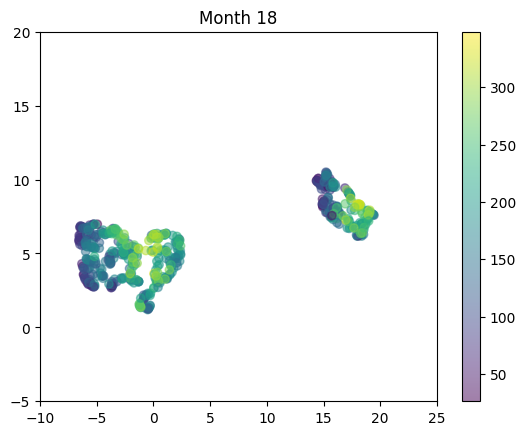

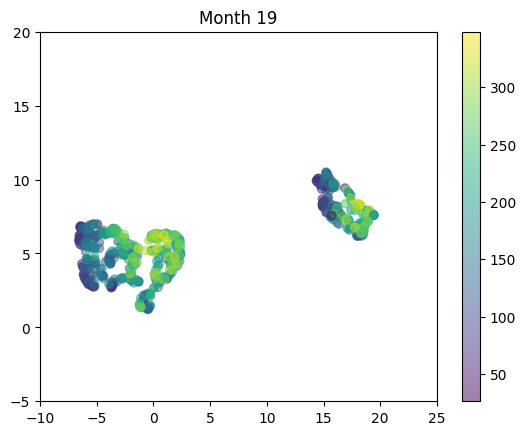

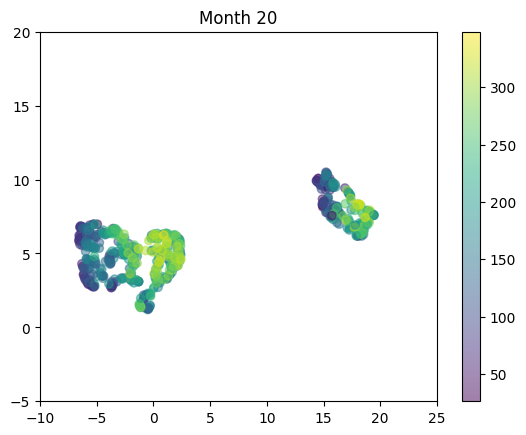

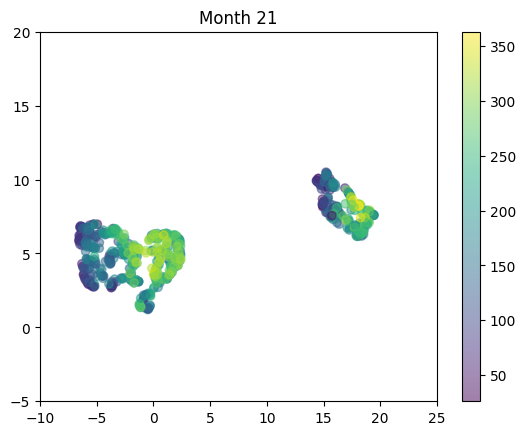

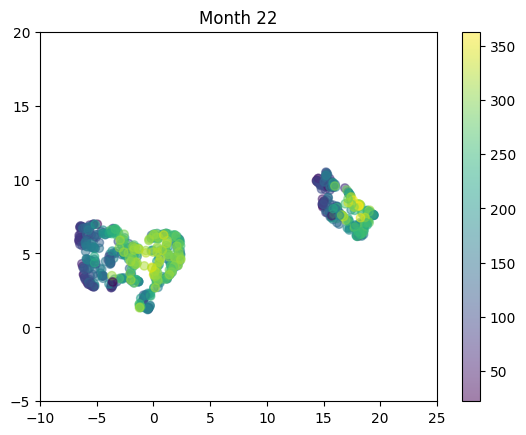

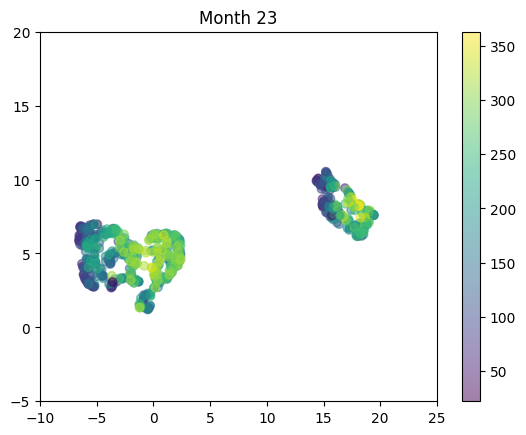

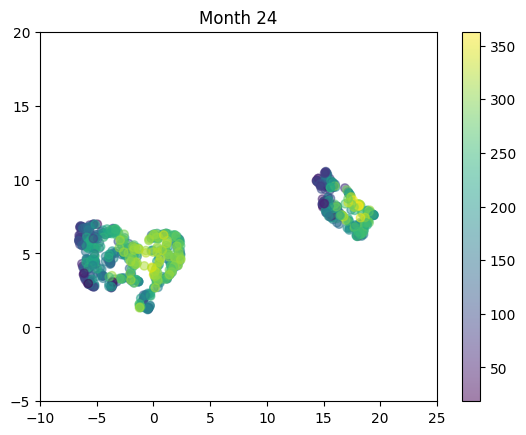

In [ ]:
os.makedirs("./plots_with_labels", exist_ok=True)
plots_with_labels = []

incremental_data_list = []
incremental_target_list = []

for month in range(len(batches_reduced)):
    new_data = batches_reduced[month]
    new_targets = targets[month].values

    incremental_data_list.append(new_data)
    incremental_target_list.append(new_targets)

    incremental_data = np.vstack(incremental_data_list)
    incremental_targets = np.hstack(incremental_target_list)

    plt.scatter(
        incremental_data[:, 0],
        incremental_data[:, 1],
        c=incremental_targets,
        cmap="viridis",
        alpha=0.5,
    )
    plt.colorbar()

    plt.title(f"Month {month+1}")
    plt.xlim((-10, 25))
    plt.ylim((-5, 20))
    # plt.axis('equal')

    filename = f"./plots_with_labels/month_{month}.png"
    plt.savefig(filename)
    plots_with_labels.append(filename)

    plt.show()

with imageio.get_writer(
    "./plots_with_labels/animation.gif", mode="I", duration=1000
) as writer:
    for filename in plots_with_labels:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

# Dynamic Clustering


In [37]:
def init_reference(data=batches_reduced[0], threshold=5):
    clustream_model = CluStream(
        max_micro_clusters=30,
        time_window=60,
        seed=0,
    )
    drift_detector = drift.PageHinkley(delta=0.0005, threshold=threshold)
    dynamic_clusterer = DynamicClusterer(
        data,
        clustream_model,
        drift_detector,
        colors,
        x_limits=(-10, 25),
        y_limits=(-5, 20),
        threshold=threshold,
    )
    return dynamic_clusterer

New model created - id: 42569
(id: 0 - cen: [14.72  9.41] - rad: 0.7)
(id: 1 - cen: [-6.23  5.52] - rad: 1.21)
<!> Change detected! Possible input drift at timestamp 15 ----> Apply macroclustering <!>

(id: 0 - cen: [14.72  9.41] - rad: 0.7) SURVIVED as (id: 0 - cen: [14.94  9.2 ] - rad: 0.82) (score: 0.8724123686633355)
(id: 1 - cen: [-6.23  5.52] - rad: 1.21) SURVIVED as (id: 1 - cen: [-5.97  5.4 ] - rad: 1.39) (score: 0.9259665666491597)
Final macroclusters:
(id: 0 - cen: [14.94  9.2 ] - rad: 0.82)
(id: 1 - cen: [-5.97  5.4 ] - rad: 1.39)

-----------------------------------------------------------------------------------



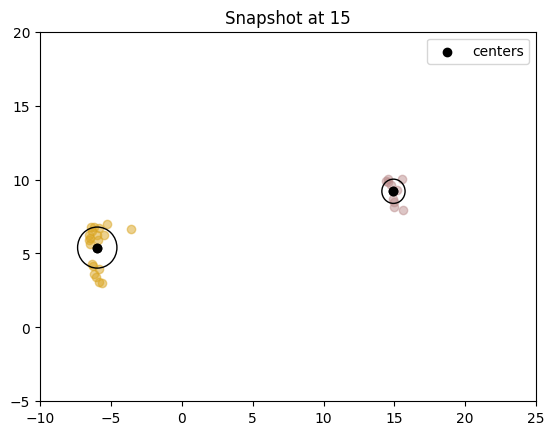

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 50 ----> Apply macroclustering <!>

(id: 1 - cen: [-5.97  5.4 ] - rad: 1.39) SURVIVED as (id: 1 - cen: [-4.95  5.13] - rad: 1.73) (score: 0.7912396841210886)
(id: 0 - cen: [14.94  9.2 ] - rad: 0.82) SURVIVED as (id: 0 - cen: [15.52  9.15] - rad: 0.99) (score: 0.8001900384712748)
Final macroclusters:
(id: 0 - cen: [15.52  9.15] - rad: 0.99)
(id: 1 - cen: [-4.95  5.13] - rad: 1.73)

-----------------------------------------------------------------------------------



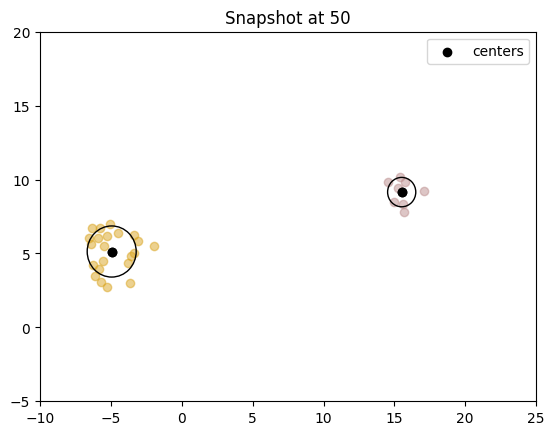

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 80 ----> Apply macroclustering <!>

(id: 1 - cen: [-4.95  5.13] - rad: 1.73) SURVIVED as (id: 1 - cen: [-3.76  4.88] - rad: 1.93) (score: 0.7939164624597386)
(id: 0 - cen: [15.52  9.15] - rad: 0.99) SURVIVED as (id: 0 - cen: [15.69  9.02] - rad: 1.07) (score: 0.9293623884854549)
Final macroclusters:
(id: 0 - cen: [15.69  9.02] - rad: 1.07)
(id: 1 - cen: [-3.76  4.88] - rad: 1.93)

-----------------------------------------------------------------------------------



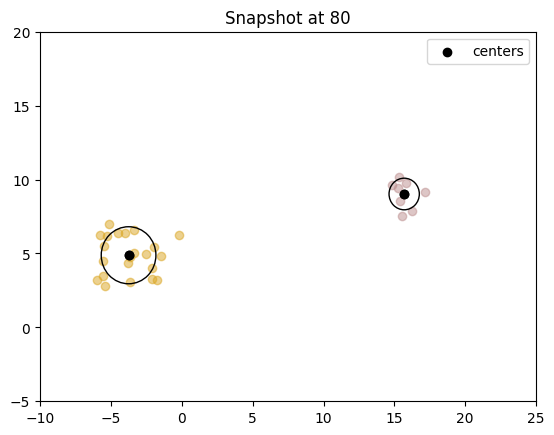

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 110 ----> Apply macroclustering <!>

(id: 1 - cen: [-3.76  4.88] - rad: 1.93) SURVIVED as (id: 1 - cen: [-2.63  4.24] - rad: 2.0) (score: 0.7963294622202715)
(id: 0 - cen: [15.69  9.02] - rad: 1.07) SURVIVED as (id: 0 - cen: [16.45  8.03] - rad: 1.22) (score: 0.6850630260726474)
Final macroclusters:
(id: 0 - cen: [16.45  8.03] - rad: 1.22)
(id: 1 - cen: [-2.63  4.24] - rad: 2.0)

-----------------------------------------------------------------------------------



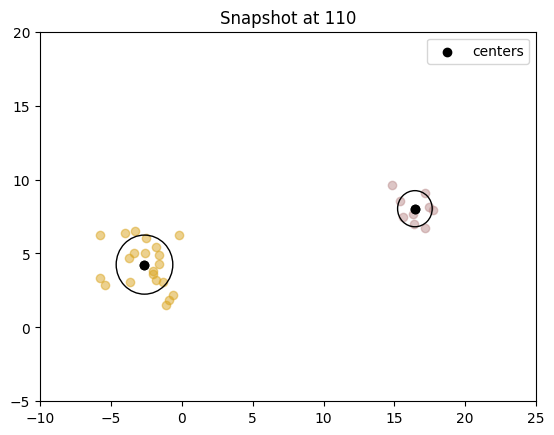

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 143 ----> Apply macroclustering <!>

(id: 1 - cen: [-2.63  4.24] - rad: 2.0) SURVIVED as (id: 1 - cen: [-0.09  4.31] - rad: 2.0) (score: 0.6429169319470972)
(id: 0 - cen: [16.45  8.03] - rad: 1.22) SURVIVED as (id: 0 - cen: [17.6   7.28] - rad: 0.96) (score: 0.6462145230996855)
Final macroclusters:
(id: 0 - cen: [17.6   7.28] - rad: 0.96)
(id: 1 - cen: [-0.09  4.31] - rad: 2.0)

-----------------------------------------------------------------------------------



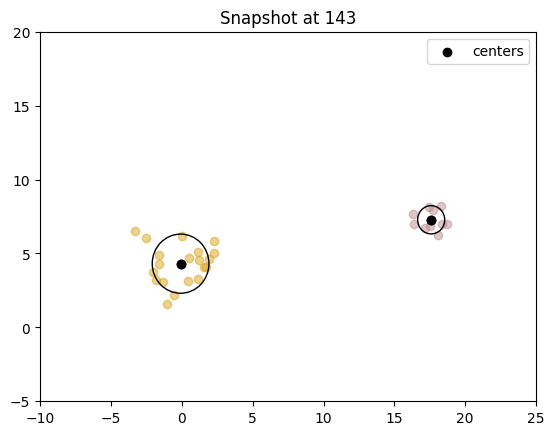

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 262 ----> Apply macroclustering <!>

(id: 1 - cen: [-0.09  4.31] - rad: 2.0) SURVIVED as (id: 1 - cen: [-1.27  3.35] - rad: 1.7) (score: 0.7519512385905207)
(id: 0 - cen: [17.6   7.28] - rad: 0.96) SURVIVED as (id: 0 - cen: [17.32  7.38] - rad: 1.02) (score: 0.9020091085648335)
Final macroclusters:
(id: 0 - cen: [17.32  7.38] - rad: 1.02)
(id: 1 - cen: [-1.27  3.35] - rad: 1.7)

-----------------------------------------------------------------------------------



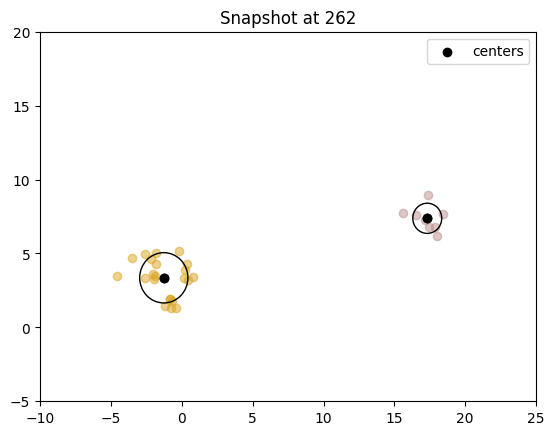

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 292 ----> Apply macroclustering <!>

(id: 1 - cen: [-1.27  3.35] - rad: 1.7) SURVIVED as (id: 1 - cen: [-2.89  3.82] - rad: 1.95) (score: 0.7257205201179892)
(id: 0 - cen: [17.32  7.38] - rad: 1.02) SURVIVED as (id: 0 - cen: [16.08  8.62] - rad: 1.26) (score: 0.585402342249425)
Final macroclusters:
(id: 0 - cen: [16.08  8.62] - rad: 1.26)
(id: 1 - cen: [-2.89  3.82] - rad: 1.95)

-----------------------------------------------------------------------------------



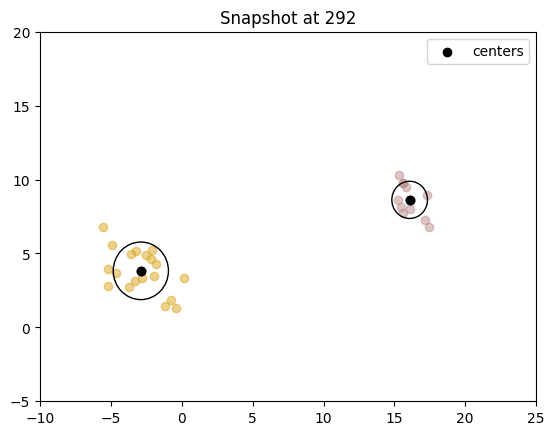

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 339 ----> Apply macroclustering <!>

(id: 1 - cen: [-2.89  3.82] - rad: 1.95) SURVIVED as (id: 1 - cen: [-5.21  4.9 ] - rad: 1.42) (score: 0.5914054730175538)
(id: 0 - cen: [16.08  8.62] - rad: 1.26) SURVIVED as (id: 0 - cen: [15.41  9.21] - rad: 0.88) (score: 0.7489181074011959)
Final macroclusters:
(id: 0 - cen: [15.41  9.21] - rad: 0.88)
(id: 1 - cen: [-5.21  4.9 ] - rad: 1.42)

-----------------------------------------------------------------------------------



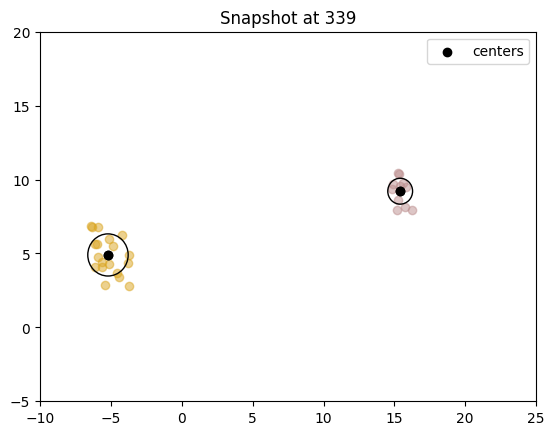

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 408 ----> Apply macroclustering <!>

(id: 1 - cen: [-5.21  4.9 ] - rad: 1.42) SURVIVED as (id: 1 - cen: [-4.25  5.27] - rad: 1.69) (score: 0.7949489586129136)
(id: 0 - cen: [15.41  9.21] - rad: 0.88) SURVIVED as (id: 0 - cen: [15.3   9.29] - rad: 0.87) (score: 0.9482545731804063)
Final macroclusters:
(id: 0 - cen: [15.3   9.29] - rad: 0.87)
(id: 1 - cen: [-4.25  5.27] - rad: 1.69)

-----------------------------------------------------------------------------------



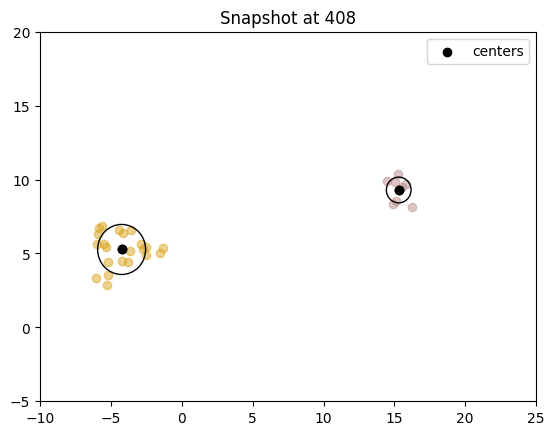

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 438 ----> Apply macroclustering <!>

(id: 1 - cen: [-4.25  5.27] - rad: 1.69) SURVIVED as (id: 1 - cen: [-3.13  5.24] - rad: 1.75) (score: 0.7977495114148587)
(id: 0 - cen: [15.3   9.29] - rad: 0.87) SURVIVED as (id: 0 - cen: [16.21  8.3 ] - rad: 1.1) (score: 0.6235165388803385)
Final macroclusters:
(id: 0 - cen: [16.21  8.3 ] - rad: 1.1)
(id: 1 - cen: [-3.13  5.24] - rad: 1.75)

-----------------------------------------------------------------------------------



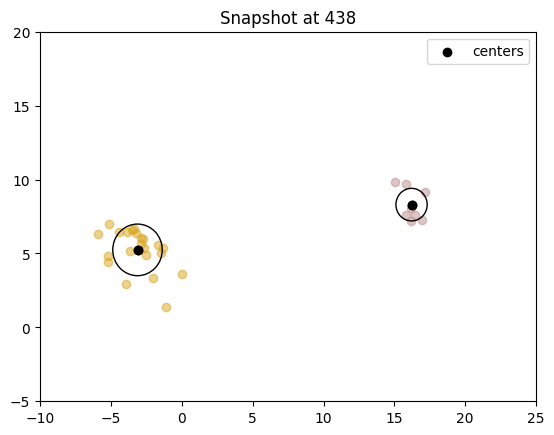

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 481 ----> Apply macroclustering <!>

(id: 1 - cen: [-3.13  5.24] - rad: 1.75) SURVIVED as (id: 1 - cen: [-2.01  4.22] - rad: 2.25) (score: 0.7687857785894979)
(id: 0 - cen: [16.21  8.3 ] - rad: 1.1) SURVIVED as (id: 0 - cen: [17.13  7.66] - rad: 1.1) (score: 0.702244631324624)
Final macroclusters:
(id: 0 - cen: [17.13  7.66] - rad: 1.1)
(id: 1 - cen: [-2.01  4.22] - rad: 2.25)

-----------------------------------------------------------------------------------



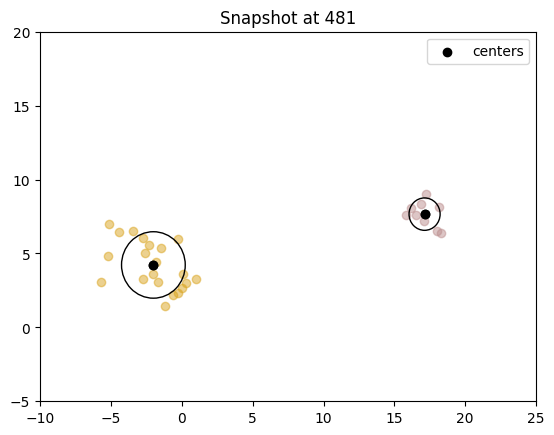

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 511 ----> Apply macroclustering <!>

(id: 1 - cen: [-2.01  4.22] - rad: 2.25) SURVIVED as (id: 1 - cen: [-0.23  4.38] - rad: 1.72) (score: 0.7319406225683435)
(id: 0 - cen: [17.13  7.66] - rad: 1.1) SURVIVED as (id: 0 - cen: [18.22  7.47] - rad: 0.96) (score: 0.6887939790034172)
Final macroclusters:
(id: 0 - cen: [18.22  7.47] - rad: 0.96)
(id: 1 - cen: [-0.23  4.38] - rad: 1.72)

-----------------------------------------------------------------------------------



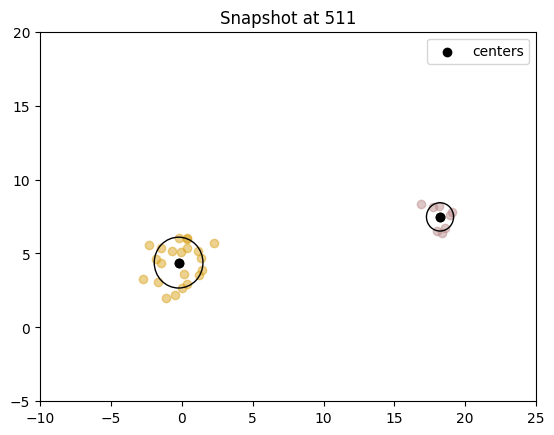

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 590 ----> Apply macroclustering <!>

(id: 1 - cen: [-0.23  4.38] - rad: 1.72) SURVIVED as (id: 1 - cen: [0.91 4.69] - rad: 1.24) (score: 0.758276933902026)
(id: 0 - cen: [18.22  7.47] - rad: 0.96) SURVIVED as (id: 0 - cen: [18.16  6.9 ] - rad: 0.71) (score: 0.7888266847442632)
Final macroclusters:
(id: 0 - cen: [18.16  6.9 ] - rad: 0.71)
(id: 1 - cen: [0.91 4.69] - rad: 1.24)

-----------------------------------------------------------------------------------



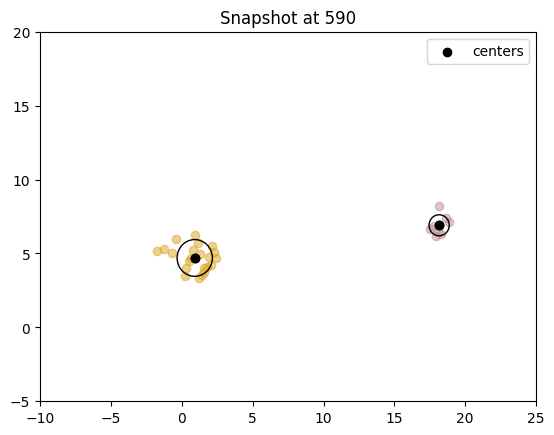

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 620 ----> Apply macroclustering <!>

(id: 1 - cen: [0.91 4.69] - rad: 1.24) SURVIVED as (id: 1 - cen: [-0.62  4.21] - rad: 1.74) (score: 0.6888195396452612)
(id: 0 - cen: [18.16  6.9 ] - rad: 0.71) SURVIVED as (id: 0 - cen: [17.6   7.66] - rad: 1.04) (score: 0.6906699092474817)
Final macroclusters:
(id: 0 - cen: [17.6   7.66] - rad: 1.04)
(id: 1 - cen: [-0.62  4.21] - rad: 1.74)

-----------------------------------------------------------------------------------



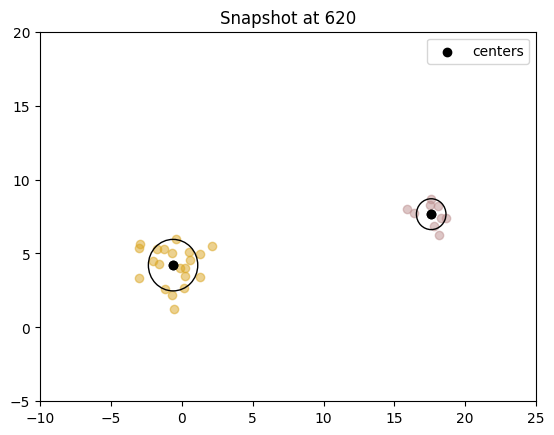

<Figure size 1000x1000 with 0 Axes>

<!> Change detected! Possible input drift at timestamp 650 ----> Apply macroclustering <!>

(id: 0 - cen: [17.6   7.66] - rad: 1.04) SURVIVED as (id: 0 - cen: [16.85  8.25] - rad: 1.02) (score: 0.7250450166135004)
(id: 1 - cen: [-0.62  4.21] - rad: 1.74) SURVIVED as (id: 1 - cen: [-2.42  4.29] - rad: 2.19) (score: 0.7275554506628263)
Final macroclusters:
(id: 0 - cen: [16.85  8.25] - rad: 1.02)
(id: 1 - cen: [-2.42  4.29] - rad: 2.19)

-----------------------------------------------------------------------------------



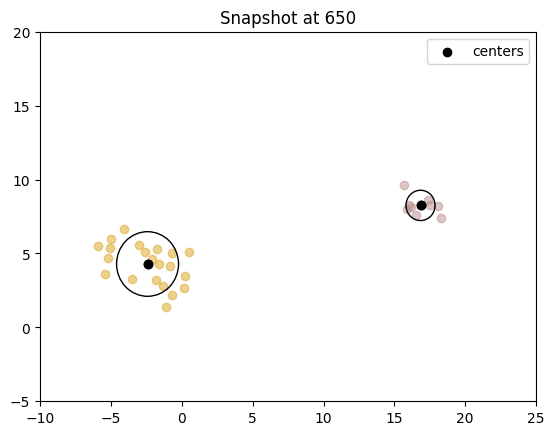

<Figure size 1000x1000 with 0 Axes>

In [38]:
clustream = init_reference()

for batch in batches_reduced[1:]:
    clustream.receive_prod(batch)
    clustream.fit_prod_data(plot_img=True, macroclustering_at_end=False)

clustream.draw_gif(title="bicycles")